In [1]:
# For linear algebra
using StaticArrays: SVector 
using LinearAlgebra
using SparseArrays: SparseMatrixCSC, sparse
# Fast Cholesky
using KoLesky 
using Plots
using PyPlot

In [2]:
function sample_points_grid(Ω, h_in, h_bd)
    x1l = Ω[1,1]
    x1r = Ω[2,1]
    x2l = Ω[1,2]
    x2r = Ω[2,2]
    x = x1l + h_in:h_in:x1r-h_in
    y = x2l + h_in:h_in:x2r-h_in
    X_domain = reduce(hcat,[[x[i], y[j]] for i in 1:length(x) for j in 1:length(x)])

    l = length(x1l:h_bd:x1r-h_bd)
    X_boundary = vcat([x1l:h_bd:x1r-h_bd x2l*ones(l)], [x1r*ones(l) x2l:h_bd:x2r-h_bd], [x1r:-h_bd:x1l+h_bd x2r*ones(l)], [x1l*ones(l) x2r:-h_bd:x1l+h_bd])
    return X_domain, X_boundary'
end

sample_points_grid (generic function with 1 method)

In [3]:
d = 2
Ω = [[0,1] [0,1]]
h_grid = 0.02
X_domain, X_boundary = sample_points_grid(Ω, h_grid, h_grid)
N_domain = size(X_domain,2); N_boundary = size(X_boundary,2)
δ_coefs = 0.0
Δδ_coefs = -1.0

meas_δ_bd = [KoLesky.PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
meas_Δδ_int = [KoLesky.ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[:,i]), Δδ_coefs, δ_coefs) for i = 1:N_domain]
measurements = Vector{Vector{<:KoLesky.AbstractPointMeasurement}}(undef,2)
measurements[1] = meas_δ_bd; measurements[2] = meas_Δδ_int;

# Exact Theta
sz = length(reduce(vcat,measurements))
Theta = zeros(sz,sz)

lengthscale = 0.3
cov = KoLesky.MaternCovariance5_2(lengthscale)
cov(Theta, reduce(vcat,measurements))

In [4]:
ρ = 3.0
k_neighbors = 1
nugget = 0.0
lambda = 1.5
alpha = 1.0

implicit_factor = KoLesky.ImplicitKLFactorization(cov, measurements, ρ, k_neighbors; lambda = lambda, alpha = alpha)
P = implicit_factor.P
U_exact = inv(cholesky(Theta[P,P]).U)

2601×2601 UpperTriangular{Float64, Matrix{Float64}}:
 1.0  -0.00128403  -0.0156107  -0.0155983    …   0.0134769     0.00443531
  ⋅    1.0         -0.0156107  -0.0155983        0.0124744     0.101199
  ⋅     ⋅           1.00024    -0.000796831      0.00703192    0.00712075
  ⋅     ⋅            ⋅          1.00024          0.0826361     0.0105211
  ⋅     ⋅            ⋅           ⋅               0.000168374   0.000506071
  ⋅     ⋅            ⋅           ⋅           …   8.8573e-7     3.70305e-6
  ⋅     ⋅            ⋅           ⋅               0.000239755   5.91234e-6
  ⋅     ⋅            ⋅           ⋅               2.61359e-7    8.06048e-5
  ⋅     ⋅            ⋅           ⋅               1.16545e-5    1.91269e-5
  ⋅     ⋅            ⋅           ⋅              -0.000399486  -7.73358e-6
  ⋅     ⋅            ⋅           ⋅           …   1.05982e-5   -3.70931e-8
  ⋅     ⋅            ⋅           ⋅               2.76695e-5   -0.000151753
  ⋅     ⋅            ⋅           ⋅              -6.98881e-6 

In [5]:
X_all = hcat(X_boundary, X_domain)

2×2601 Matrix{Float64}:
 0.0  0.02  0.04  0.06  0.08  0.1  …  0.98  0.98  0.98  0.98  0.98  0.98
 0.0  0.0   0.0   0.0   0.0   0.0     0.88  0.9   0.92  0.94  0.96  0.98

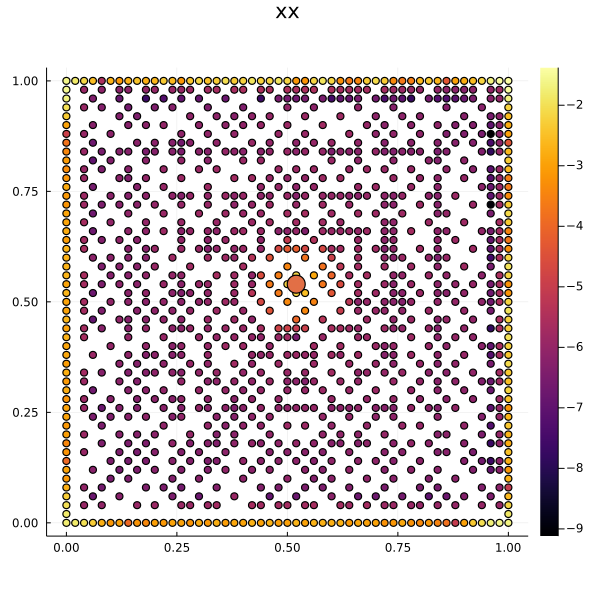

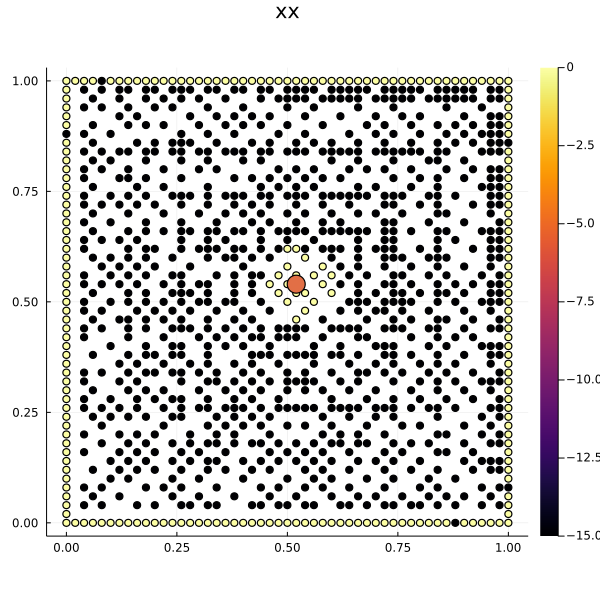

In [16]:
pts_idx = floor(Int,((1/h_grid+1)^2)*0.45)

plts = Plots.scatter(X_all[1,P[1:pts_idx]],X_all[2,P[1:pts_idx]], marker_z = log.(abs.(U_exact[1:pts_idx, pts_idx]).+1e-15)/log(10), title = "xx", legend = false,  colorbar = true)
Plots.scatter!([X_all[1,P[pts_idx]]],[X_all[2,P[pts_idx]]], markersize = 10, aspect_ratio=:equal, size=(600,600), legend = false)
display(plts)

val = log.(abs.(U_exact[1:pts_idx, pts_idx]).+1e-15)/log(10)
threshold = max(val...)-3
val[val .<= threshold] .= -15
val[val .> threshold] .= 0


plts2 = Plots.scatter(X_all[1,P[1:pts_idx]],X_all[2,P[1:pts_idx]], marker_z = val, title = "xx", legend = false,  colorbar = true)
Plots.scatter!([X_all[1,P[pts_idx]]],[X_all[2,P[pts_idx]]], markersize = 10, aspect_ratio=:equal, size=(600,600), legend = false)
display(plts2)

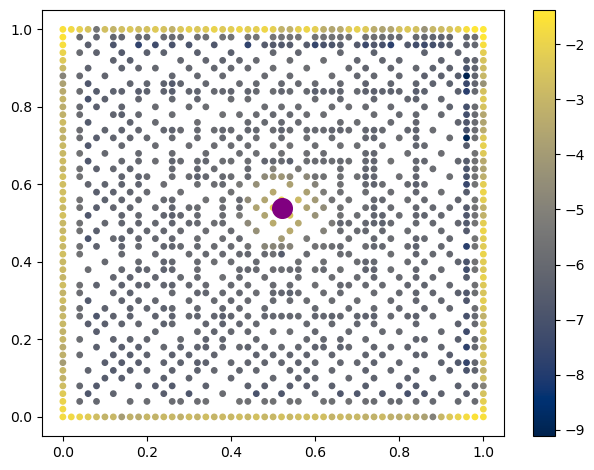

In [17]:
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=false)
sm = ax.scatter(X_all[1,P[1:pts_idx]],X_all[2,P[1:pts_idx]],s=15,c=log.(abs.(U_exact[1:pts_idx, pts_idx]).+1e-15)/log(10), cmap = "cividis", alpha = 1)
fig.colorbar(sm, ax=ax)
# ax.set_xlabel(L"x")
# ax.set_ylabel(L"y")
ax.scatter([X_all[1,P[pts_idx]]],[X_all[2,P[pts_idx]]], s=200, c="purple")
fig.tight_layout()
fig.savefig("ReducedMtx_int.pdf")

In [ ]:
explicit_factor = KoLesky.ExplicitKLFactorization(implicit_factor; nugget = nugget)
U = copy(explicit_factor.U)
U.nzval .= 1.0
U = Matrix(U)
truncation_U = U.*U_exact
@show length((explicit_factor.U.nzval))

invTheta = inv(Theta[P,P]+nugget*diagm(diag(Theta[P,P])))
opnorm_invTheta = opnorm(invTheta)
@show opnorm(invTheta - Matrix(truncation_U*truncation_U'))/opnorm_invTheta
@show opnorm(invTheta - Matrix(explicit_factor.U*explicit_factor.U'))/opnorm_invTheta
@show opnorm_invTheta

truncation_U_inv = inv(Matrix(truncation_U))
opnorm_Theta = opnorm(Theta[P,P])
@show opnorm(Theta[P,P] - truncation_U_inv'*truncation_U_inv)/opnorm_Theta
U_inv = inv(Matrix(explicit_factor.U))
@show opnorm(Theta[P,P] - U_inv'*U_inv)/opnorm_Theta
@show opnorm_Theta



In [ ]:
# Measurements
d = 2
Ω = [[0,1] [0,1]]
h_grid = 0.02
X_domain, X_boundary = sample_points_grid(Ω, h_grid, h_grid)
N_domain = size(X_domain,2); N_boundary = size(X_boundary,2)
δ_coefs = 0.0
Δδ_coefs = -1.0

meas_δ_bd = [KoLesky.PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
meas_δ_int = [KoLesky.PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]
meas_Δδ_int = [KoLesky.ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[:,i]), Δδ_coefs, δ_coefs) for i = 1:N_domain]
measurements = Vector{Vector{<:KoLesky.AbstractPointMeasurement}}(undef,3)
measurements[1] = meas_δ_bd; measurements[2] = meas_δ_int;; measurements[3] = meas_Δδ_int;

sz = length(reduce(vcat,measurements))
Theta = zeros(sz,sz)

lengthscale = 0.3
cov = KoLesky.MaternCovariance5_2(lengthscale)
cov(Theta, reduce(vcat,measurements))

In [ ]:
ρ = 3.0
k_neighbors = 1
nugget = 0.0
lambda = 1.5
alpha = 1.0

implicit_factor = KoLesky.ImplicitKLFactorization(cov, measurements, ρ, k_neighbors; lambda = lambda, alpha = alpha)
P = implicit_factor.P
U_exact = inv(cholesky(Theta[P,P]).U)

X_all = hcat(X_boundary, X_domain)
pts_idx = floor(Int,((1/h_grid+1)^2)*0.55) + N_domain # the second set of measurements

plts = Plots.scatter(X_all[1,P[1:N_domain+N_boundary]],X_all[2,P[1:N_domain+N_boundary]], marker_z = log.(abs.(U_exact[1:N_domain+N_boundary, pts_idx]).+1e-15)/log(10), legend = false,  colorbar = true)
Plots.scatter!([X_all[1,P[pts_idx]-N_domain]],[X_all[2,P[pts_idx]-N_domain]], markersize = 10, aspect_ratio=:equal, size=(640,600), legend = false)
display(plts)
Plots.savefig(plts, "DiracsFirst_julia.pdf")

val = log.(abs.(U_exact[1:N_domain+N_boundary, pts_idx]).+1e-15)/log(10)
threshold = max(val...)-3
val[val .<= threshold] .= -15
val[val .> threshold] .= 0


plts2 = Plots.scatter(X_all[1,P[1:N_domain+N_boundary]],X_all[2,P[1:N_domain+N_boundary]], marker_z = val, legend = false,  colorbar = true)
Plots.scatter!([X_all[1,P[pts_idx]-N_domain]],[X_all[2,P[pts_idx]-N_domain]], markersize = 10, aspect_ratio=:equal, size=(640,600), legend = false)
display(plts2)

In [ ]:
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=false)
sm = ax.scatter(X_all[1,P[1:N_domain+N_boundary]],X_all[2,P[1:N_domain+N_boundary]],s=15,c=log.(abs.(U_exact[1:N_domain+N_boundary, pts_idx]).+1e-15)/log(10), cmap = "cividis", vmin=-12, vmax=2, alpha = 1)
fig.colorbar(sm, ax=ax)
# ax.set_xlabel(L"x")
# ax.set_ylabel(L"y")
ax.scatter([X_all[1,P[pts_idx]-N_domain]],[X_all[2,P[pts_idx]-N_domain]], s=200, c="purple")
fig.tight_layout()
fig.savefig("DiracsFirst.pdf")

In [ ]:
# Measurements
d = 2
Ω = [[0,1] [0,1]]
h_grid = 0.02
X_domain, X_boundary = sample_points_grid(Ω, h_grid, h_grid)
N_domain = size(X_domain,2); N_boundary = size(X_boundary,2)
δ_coefs = 0.0
Δδ_coefs = -1.0

meas_δ_bd = [KoLesky.PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
meas_δ_int = [KoLesky.PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]
meas_Δδ_int = [KoLesky.ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[:,i]), Δδ_coefs, δ_coefs) for i = 1:N_domain]
measurements = Vector{Vector{<:KoLesky.AbstractPointMeasurement}}(undef,3)
measurements[1] = meas_Δδ_int; measurements[3] = meas_δ_bd; measurements[2] = meas_δ_int;

sz = length(reduce(vcat,measurements))
Theta = zeros(sz,sz)

lengthscale = 0.3
cov = KoLesky.MaternCovariance5_2(lengthscale)
cov(Theta, reduce(vcat,measurements))


ρ = 3.0
k_neighbors = 1
nugget = 0.0
lambda = 1.5
alpha = 1.0

implicit_factor = KoLesky.ImplicitKLFactorization(cov, measurements, ρ, k_neighbors; lambda = lambda, alpha = alpha)
P = implicit_factor.P
U_exact = inv(cholesky(Theta[P,P]).U)

X_all = hcat(X_boundary, X_domain)
# pts_idx = floor(Int,((1/h_grid+1)^2)*0.55) + N_domain # the second set of measurements
# pts_idx = N_domain + N_boundary + 10
pts_idx = N_domain + 10

# plts = scatter(X_domain[1,P[1:N_domain]],X_domain[2,P[1:N_domain]], marker_z = log.(abs.(U_exact[1:N_domain, pts_idx]).+1e-15)/log(10), title = "xx", legend = false,  colorbar = true)
# scatter!([X_all[1,P[pts_idx]-N_domain]],[X_all[2,P[pts_idx]-N_domain]], markersize = 10, aspect_ratio=:equal, size=(600,600), legend = false)
# display(plts)

# val = log.(abs.(U_exact[1:N_domain, pts_idx]).+1e-15)/log(10)
# threshold = max(val...)-3
# val[val .<= threshold] .= -15
# val[val .> threshold] .= 0


# plts2 = scatter(X_domain[1,P[1:N_domain]],X_domain[2,P[1:N_domain]], marker_z = val, title = "xx", legend = false,  colorbar = true)
# scatter!([X_all[1,P[pts_idx]-N_domain]],[X_all[2,P[pts_idx]-N_domain]], markersize = 10, aspect_ratio=:equal, size=(600,600), legend = false)
# display(plts2)

In [ ]:
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=false)
sm = ax.scatter(X_domain[1,P[1:N_domain]],X_domain[2,P[1:N_domain]],s=15,c=log.(abs.(U_exact[1:N_domain, pts_idx]).+1e-15)/log(10), cmap = "cividis", alpha = 1)
fig.colorbar(sm, ax=ax)
# ax.set_xlabel(L"x")
# ax.set_ylabel(L"y")
ax.scatter([X_domain[1,P[pts_idx]-N_domain]],[X_domain[2,P[pts_idx]-N_domain]], s=200, c="purple")
fig.tight_layout()
fig.savefig("DerivativeFirst.pdf")